# Analysis and Visualisation

In [5]:
import pandas as pd
from pathlib import Path
import seaborn as sns
from classes import * 

In [24]:
df = pd.read_csv(Path('processed_loan_payments.csv'))

to_date_list = ['issue_date',
                'earliest_credit_line', 
                'last_payment_date', 
                 
                'last_credit_pull_date']
to_numeric_list = []
to_categorical_list = ['term',
                       'grade', 
                       'sub_grade', 
                       'home_ownership', 
                       'verification_status', 
                       'loan_status', 
                       'purpose', 
                       'policy_code', 
                       'application_type',
                       'id',
                       'member_id']

df = DataTransform(df).to_date(to_date_list)
df = DataTransform(df).to_numeric(to_numeric_list)
df = DataTransform(df).to_categorical(to_categorical_list)


## Current State of Loans
To examine the current state of loans, we must calculate the percentage of the loans that are recovered against the investor funding and the total amount funded. These categorical results can be shown on a bar graph.

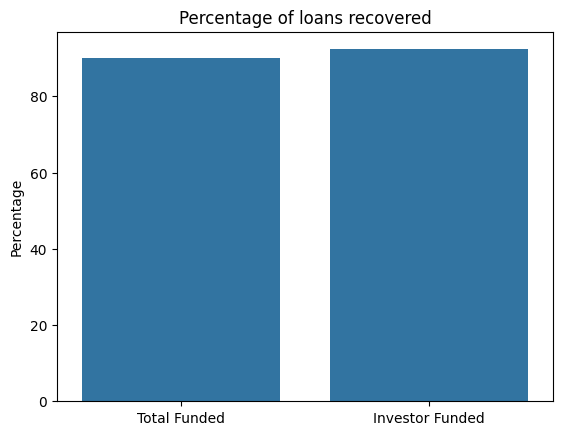

Percentage of loans recovered vs total funding:90.15935572391416%
Percentage of loans recovered vs investor funding:92.32075171371189%


In [25]:
total_payments_percentage = DataFrameInfo(df).column_percentage('total_payment', 'funded_amount')
total_payments_percentage_inv = DataFrameInfo(df).column_percentage('total_payment', 'funded_amount_inv')

sns.barplot(x=['Total Funded', 'Investor Funded'], y=[total_payments_percentage, total_payments_percentage_inv])
pyplot.ylabel('Percentage')
pyplot.title('Percentage of loans recovered')
pyplot.show()
print(f'Percentage of loans recovered vs total funding:{total_payments_percentage}%')
print(f'Percentage of loans recovered vs investor funding:{total_payments_percentage_inv}%')

The percentage of funding recovered has a negligible difference between the total funding and investor funding. We can also visualise what percentage of the total amount would be recovered up to 6 months in the future.

Percent of Loans Recovered per month
Month 1
2.98 %
Month 2
5.94 %
Month 3
8.88 %
Month 4
11.81 %
Month 5
14.71 %
Month 6
17.59 %


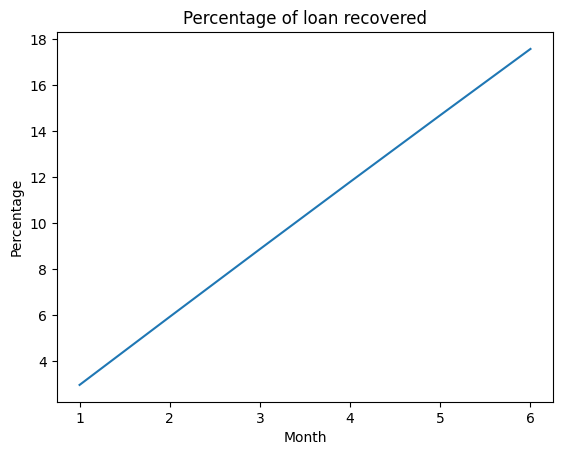

In [36]:
print('Percent of Loans Recovered per month')
collection_pcent_dict = {}
for i in range(1,7):
    print('Month',i)    
    collections_df = DataFrameInfo(df).total_recovered_over_period(i)
    collection_pcent = DataFrameInfo(collections_df).column_percentage('collections_over_period','loan_amount')
    collection_pcent_dict[i] = collection_pcent
    print(round(collection_pcent,ndigits=2),'%')

sns.lineplot(x= list(collection_pcent_dict.keys()), y=list(collection_pcent_dict.values()))
pyplot.xlabel('Month')
pyplot.ylabel('Percentage')
pyplot.title('Percentage of loan recovered')
pyplot.show()

As expected, the total amount of loans recovered over the next 6 months follows a linear trend. This relationship will most likely look different for longer forecasts as a large proportion of loans are fulfiled. This model also assumes all scheduled instalments are paid, a factor that may impact the reliability of this prediction as we extrapolate further.